In [1]:
import sys
import time
import numpy as np
import pylab as pl

sys.path.append('../') # get out of the sandbox

from vent.controller.control_module import get_control_module, Balloon_Simulator
from vent.common.message import SensorValues, ControlSetting, Alarm, AlarmSeverity
from vent.common.values import ValueName, CONTROL

In [2]:
Controller = get_control_module(sim_mode=True)

In [3]:
Controller.start()

ls = []
tt = []
t0 = time.time()
for t in np.arange(0, 10,0.05):
    
    if t%5==0:  # ask for a heartbeat from thread every 5 seconds
        print(Controller.heartbeat())
    
    
    ## Do things
    command = ControlSetting(name=ValueName.PEEP, value=3, min_value=1, max_value=4, timestamp=time.time())
    Controller.set_control(command)

    command = ControlSetting(name=ValueName.PIP, value=40, min_value=38, max_value=42, timestamp=time.time())
    Controller.set_control(command)

    command = ControlSetting(name=ValueName.BREATHS_PER_MINUTE, value=20, min_value=19, max_value=21, timestamp=time.time()) 

    Controller.set_control(command)

    v_iphase = 0.4 * 60/20  #0.3 and 0.8
    command = ControlSetting(name=ValueName.INSPIRATION_TIME_SEC, value=v_iphase, min_value=v_iphase - 1, max_value=v_iphase + 1, timestamp=time.time())
    Controller.set_control(command)
    
    ##
    
    
    vals = Controller.get_sensors()
    ls.append(vals)
    tt.append(time.time()  - t0)
    
    time.sleep(0.05)
    
Controller.stop()

0
455


In [4]:
# Get the target waveform, and plot together with the last measured waveform

In [5]:
pas_wv = Controller.get_past_waveforms()
wv = Controller.get_target_waveform()

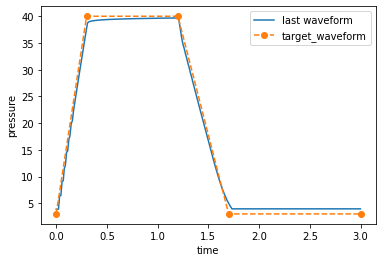

In [6]:
lastwv = pas_wv[-1]
pl.plot(lastwv[:,0], lastwv[:,1], label='last waveform')
pl.plot([pt[0] for pt in wv], [pt[1] for pt in wv], '--o', label = 'target_waveform')
pl.legend()
pl.xlabel('time')
pl.ylabel("pressure");

In [7]:
# Current controller alerts

Text(0.5, 0, 'time [s]')

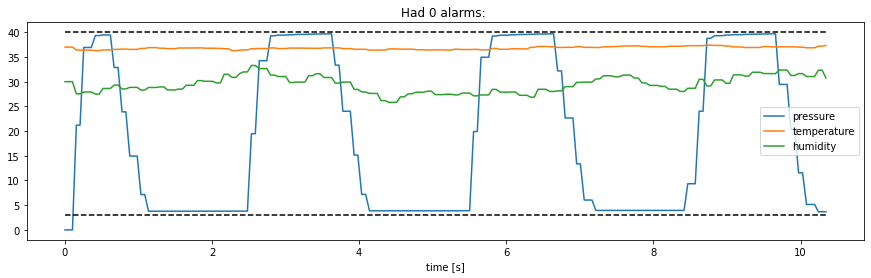

In [8]:
pl.rcParams['figure.figsize'] = [15, 4]

cc = Controller.get_control(control_setting_name = ValueName.PEEP)
peep = cc.value

cc = Controller.get_control(control_setting_name = ValueName.PIP)
pip = cc.value

pl.plot(tt, [s.PRESSURE for s in ls], label = 'pressure')
pl.plot(tt, [s.TEMP for s in ls], label = "temperature")
pl.plot(tt, [s.HUMIDITY/3 for s in ls], label = "humidity")
pl.plot([np.min(tt), np.max(tt)], [pip, pip], 'k--')
pl.plot([np.min(tt), np.max(tt)], [peep, peep], 'k--')

active_alarms = Controller.get_active_alarms()
logged_alarms = Controller.get_logged_alarms()

pc = 0
for active_alarm_key in active_alarms.keys():
    alarm = active_alarms[active_alarm_key]
    pl.plot([alarm.alarm_start_time-t0+pc, alarm.alarm_start_time-t0+pc], [0,25], 'r-')
    pc += 0.1

pc=0
for alarm in logged_alarms:
    pl.plot([alarm.alarm_start_time-t0+pc, alarm.alarm_start_time-t0+pc], [0,25-7*pc], 'b-')
    pl.plot([alarm.alarm_start_time-t0+pc, alarm.alarm_end_time-t0+pc],  [25-7*pc,25-7*pc], 'b-')
    pc += 0.1

s = "Had " + str(len(Controller.get_alarms())) + " alarms: "
for alarm in Controller.get_alarms():
    s = s + str(alarm.alarm_name) + ", "
    
pl.title(s)
pl.legend()
pl.xlabel("time [s]")